In [1]:
# 自作モジュールの参照先を上書き
import sys
parent_dir = 'Predict-Future-Sales'
p_sub = sys.path[0]

ride = ''
for path in p_sub.split('/'):
    if path != parent_dir:
        ride = ride + path + '/'
    else:
        ride = ride + path + '/'
        break
sys.path[0] = ride


import time
import pickle

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import torch.nn as nn
from torch.optim import Adam

from module.lino_module.preprocess import mode_of_freq, univariate_dataset, select_device
from module.lino_module.model import TransformerModel
from module.lino_module.training import training
from module.lino_module.ploter import learning_plot, confirmation, uni_time_series,\
                                        confirmation_plot

# 乱数固定
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

In [2]:
saving = True

data = pd.read_csv('../data/sales_train.csv')
data = mode_of_freq(data).item_cnt_day
seq = 10
dilation = 1
src_tgt_seq = (10, 4)
step_num = 4
scaler = StandardScaler

dataset_kw = {'data': data,
              'seq': seq,
              'dilation': dilation,
              'src_tgt_seq': src_tgt_seq,
              'step_num': step_num,
              'daily': False,
              'weekday': False,
              'weekly': True,
              'monthly': False,
              'scaler': scaler,
              'batch_size': 64,
              'train_rate': 0.9}

train, test = univariate_dataset(**dataset_kw)
print(f'seq: {seq}, src_tgt_seq: {src_tgt_seq}, step_num: {step_num}')
src, tgt, y = next(iter(train))
src.shape, tgt.shape, y.shape

seq: 10, src_tgt_seq: (10, 4), step_num: 4


(torch.Size([64, 10, 2]), torch.Size([64, 4, 2]), torch.Size([64, 4]))

In [3]:
# device = select_device() # mps では Transformer の attention でエラー
device = torch.device('cpu')
cat_dim = dataset_kw['daily'] + dataset_kw['weekday'] + dataset_kw['weekly'] + dataset_kw['monthly']
dim = cat_dim + 1

# 入力時線形層の出力次元
d_model = dim * 16

model_kw = {'input_dim': dim,
            'd_model': d_model,
            'nhead': 8,
            'device': device
            }

# モデルと損失関数
transformer = TransformerModel(**model_kw).to(device)
# criterion = RMSELoss()  # 論文ではRMSELoss
criterion = nn.MSELoss().to(device)

# 学習率その他は論文の値を参考
warmup_steps = 5000
lr = d_model**0.5 * min(step_num**0.5, step_num * warmup_steps**(-1.5))
optimizer = Adam(transformer.parameters(), lr=lr, betas=(0.95, 0.98), eps=10e-9)
print('lr rate: ', lr)

lr rate:  6.4e-05


In [4]:
epochs = 100
training_kwrgs = {'model': transformer,
                  'train': train,
                  'test': test,
                  'device': device,
                  'criterion': criterion,
                  'optimizer': optimizer,
                  'epochs': epochs,
                  'early_stopping': 5,
                  'verbose': 10,
                  'center': 70}
transformer, loss_pack = training(**training_kwrgs)
train_loss, validation_loss, test_loss = loss_pack

------------------------------- start --------------------------------
                               epoch_0                                
train_loss:  1.7182 | validation_loss:  1.7681 | test_loss:  2.175
                               epoch_10                               
train_loss:  0.6894 | validation_loss:  0.6176 | test_loss:  0.2558
                               epoch_20                               
train_loss:  0.5401 | validation_loss:  0.4571 | test_loss:  0.1847
                               epoch_30                               
train_loss:  0.4963 | validation_loss:  0.4169 | test_loss:  0.1817
                               epoch_40                               
train_loss:  0.4738 | validation_loss:  0.3943 | test_loss:  0.1763
                               epoch_50                               
train_loss:  0.4522 | validation_loss:  0.3826 | test_loss:  0.1738
                               epoch_60                               
train_loss:  0.4346 | val

In [5]:
# ファイル名の作成
name = ''
del dataset_kw['batch_size'], dataset_kw['train_rate']
for key, value in dataset_kw.items():
    if key=='data':
        pass
    elif key=='scaler':
        name += f'{key}({value.__name__})'
    else:
        name += f'{key}({value})'

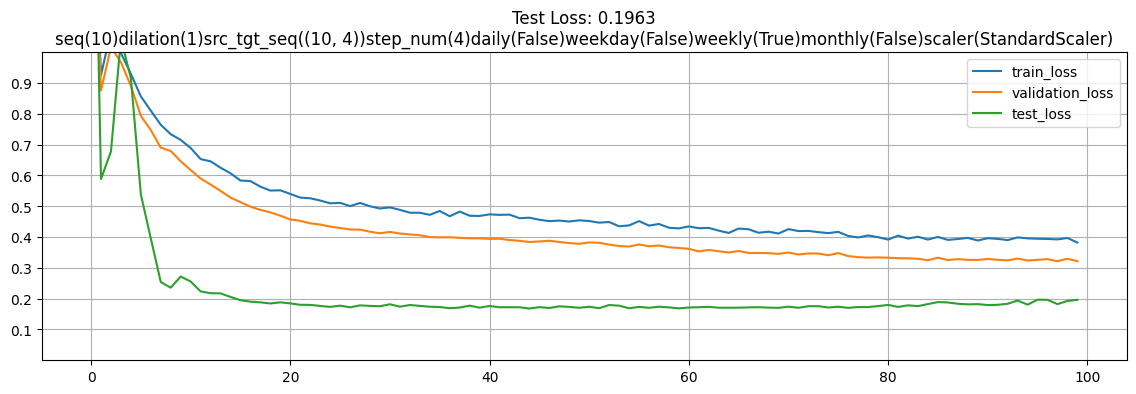

In [6]:
img_path = './imgs/img_wm/'
figsize = (14, 4)
learning_plot(train_loss, validation_loss, test_loss,  img_path, name, scaler, figsize, saving)

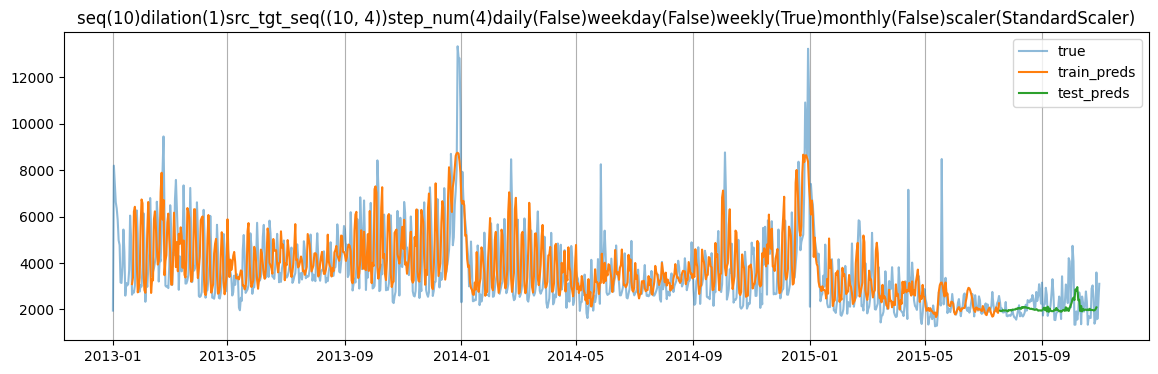

In [7]:
figsize = (14, 4)
train_preds, test_preds = confirmation(transformer, train, test, device)
train_time_series, test_time_series, original = uni_time_series(data, train_preds, test_preds, scaler, d_model, dilation, seq)
confirmation_plot(train_time_series, test_time_series, original, img_path, name, figsize, saving)

In [8]:
if saving:
    # 訓練済みモデルパラメータの保存
    model_dir = './models/model/'
    torch.save(transformer.state_dict(), model_dir + name + '.pht')

    # 訓練時引数の保存
    inf_dir = model_dir + 'kw_inf/'
    kw_obj = {'dataset': dataset_kw, 'model': model_kw}
    with open(inf_dir + name + '.pkl', 'wb') as f:
        pickle.dump(kw_obj, f)
    print('model is saved')
else:
    print('Not saved')

model is saved


In [9]:
params = 0
for p in transformer.parameters():
    if p.requires_grad:
        params += p.numel()
        
print(params)

1117313
